Este projeto o trabalho de fim de curso do aluno Igor Peterossi Lopes (RA:174929) para o curso de engenharia elétrica da Unicamp, feito no 2 semestre de 2022.

Este trabalho pretende resolver um problema de classificação binária através de duas estratégias distintas: utilizando um classificador implementado com regressão logística e utilizando um classificador feito com uma rede neural e através dos resultados obtidos comparar os dois métodos de resolução do problema.

O problema que esta sendo analisado é o da classificação de websites em sites de phishing e sites seguros (que não são de phishing), os dados para essa classificação fazem parte do acervo de machine learning da University of California, School of Information and Computer Science, disponível no seguinte link: https://archive.ics.uci.edu/ml/datasets/phishing+websites


In [1]:
# Configurações técnicas gerais para a realização do projeto

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

Como primeira etapa, obtemos os dados que serão estudados e depois passamos a fazer pequenas adaptações nestes a fim de viabilizar a sua utilização pelos modelos que serão desenvolvidos

In [2]:
from sklearn.datasets import fetch_openml

X_data, y_data = fetch_openml(data_id=4534, return_X_y=True)
X_data = X_data.astype("int64")
y_data = y_data.astype("int64")

def map_output(value):
    if value == -1:
        return 0
    return value

y_data = y_data.apply(map_output)

In [3]:
# y_data = y_data[:1000]
# X_data = X_data[:1000]
# X_data= X_data.loc[:, 'port':'SFH']

# Drop das melhores features
# X_data = X_data.drop(columns=['SSLfinal_State'])
# X_data = X_data.drop(columns=['URL_of_Anchor'])

Agora realizamos algumas observações em cima dos dados para que possamos compreender melhor as suas características
Começamos unindo o dataset de features com o dos resultados, para facilitar nossas análises

In [4]:
complete_data = X_data.copy(deep=True)
complete_data["Result"] = y_data
complete_data.head()

having_IP_Address  URL_Length  Shortining_Service  having_At_Symbol  \
0                 -1           1                   1                 1   
1                  1           1                   1                 1   
2                  1           0                   1                 1   
3                  1           0                   1                 1   
4                  1           0                  -1                 1   

   double_slash_redirecting  Prefix_Suffix  having_Sub_Domain  SSLfinal_State  \
0                        -1             -1                 -1              -1   
1                         1             -1                  0               1   
2                         1             -1                 -1              -1   
3                         1             -1                 -1              -1   
4                         1             -1                  1               1   

   Domain_registeration_length  Favicon  ...  popUpWidnow  Iframe  \
0                           -1        1  ...            1       1   
1                           -1        1  ...            1       1   
2                           -1        1  ...            1       1   
3                            1        1  ...            1       1   
4                           -1        1  ...           -1       1   

   age_of_domain  DNSRecord  web_traffic  Page_Rank  Google_Index  \
0             -1         -1           -1         -1             1   
1             -1         -1            0         -1             1   
2              1         -1            1         -1             1   
3             -1         -1            1         -1             1   
4             -1         -1            0         -1             1   

   Links_pointing_to_page  Statistical_report  Result  
0                       1                  -1       0  
1                       1                   1       0  
2                       0                  -1       0  
3                      -1                   1       0  
4                       1                   1       1  

[5 rows x 31 columns]

Observando como as nossas classes estão distribuídas (sites classificados como phishing x sites normais), notamos uma quantidade ligeiramente maior de casos "positivos", sites identificados como de phishing, em relação aos casos negativos (sites que não são de phishing), ainda sim o dataset é bem equilibrado

<AxesSubplot: xlabel='Values', ylabel='Websites'>

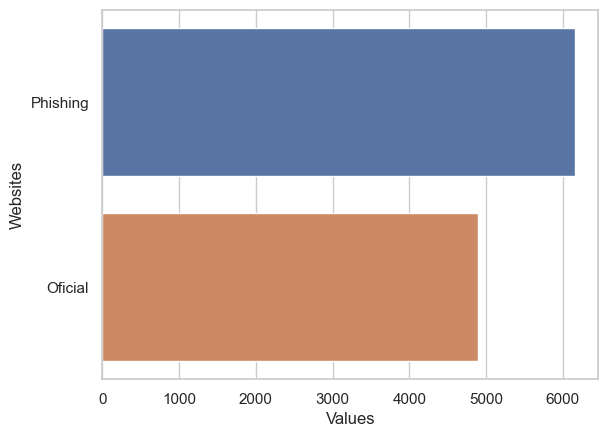

In [5]:
series = complete_data['Result'].value_counts()
total_classes = pd.DataFrame({'Websites': ['Phishing', 'Oficial'], 'Values': [series[1], series[0]]})
sns.barplot(x = 'Values', y = 'Websites', data = total_classes)

Analisamos também a correlação entre cada feature disponível no nosso dataset e a classificação entre phishing e oficial

In [6]:
result_correlation_df = complete_data.corr()[['Result']].sort_values(by='Result', ascending=False)

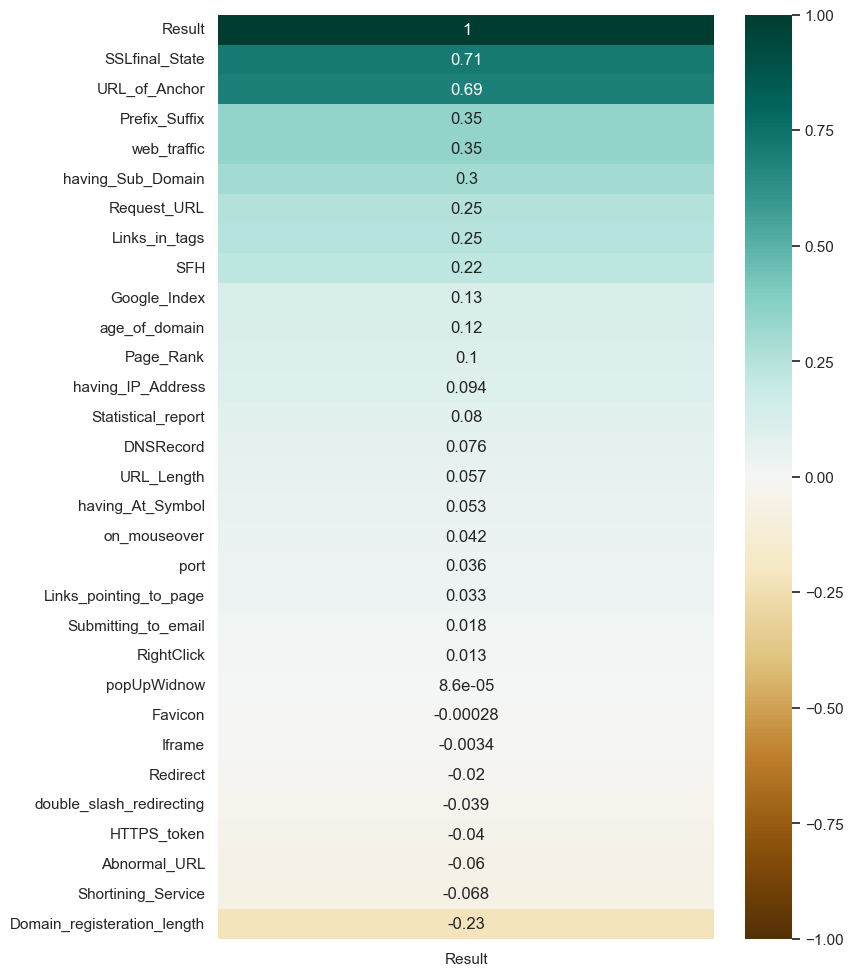

In [7]:
plt.figure(figsize=(8, 12))
mask = np.triu(np.ones_like(result_correlation_df, dtype=bool))
heatmap = sns.heatmap(result_correlation_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')

Com base nas informações de correlação acima, podemos simplificar o nosso dataset eliminando todas as features que apresentam correlação mínima como resultado, ou seja, que pouco influênciam na identificação de um site como de phishing

In [8]:
X_data = X_data.drop(columns=['having_IP_Address', 'Statistical_report', 'DNSRecord', 'URL_Length', 'having_At_Symbol', 'on_mouseover', 'port', 'Links_pointing_to_page', 'Submitting_to_email', 'RightClick', 'popUpWidnow', 'Favicon', 'Iframe', 'Redirect', 'double_slash_redirecting', 'HTTPS_token', 'Abnormal_URL', 'Shortining_Service'])

Primeiro, criamos o modelo de regressão logística. Usaremos a biblioteca scikit-learn para auxiliar no desenvolvimento do modelo, bem como na separação dos nossos dados em partes para treinamento e para validação posterior

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

Com o nosso modelo de regressão treinado, vamos agora identificar a sua performance, determinando a sua acurácia e também plotando uma matriz de confusão

In [10]:
y_pred = logreg.predict(X_test)
print('Acurácia do classificador de regressão logística no dataset de teste: {:.3f}'.format(logreg.score(X_test, y_test)))

Acurácia do classificador de regressão logística no dataset de teste: 0.919


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1498
           1       0.91      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1328  170]
 [ 100 1719]]


Agora trabalharemos com o nosso modelo de deep learning. Implementamos uma rede neural de duas camadas, sendo uma camada interna com um nó para cada feature do dataset (30 nós ao todo), com uma função de ativação ReLu e uma camada externa que consolida o resultado anterior utilizando uma função sigmoide.
O modelo é montado para minimizar a função "binary cross entropy", usualmente utilizada para resolução de problemas de classificação binária, buscando otimizar a acurácia do classificador. O modelo

In [13]:
from sklearn.svm import LinearSVC

svm=LinearSVC(C=0.0001)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1498
           1       0.90      0.94      0.92      1819

    accuracy                           0.91      3317
   macro avg       0.91      0.91      0.91      3317
weighted avg       0.91      0.91      0.91      3317



In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(X_data.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2022-11-25 20:26:58.908532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 20:27:08.313912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                390       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


Agora treinamos a nossa rede neural utilizando a mesma separação do dataset utilizada para o modelo de regressão logística, em batches de 100 e em 10 epochs. Depois avaliamos a sua perfomance, computando a acurácia final do modelo, a sua progressão após cada passo do treinamento e também a matriz de confusão

In [15]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=100, verbose=False)

print('Acurácia da rede neural no dataset de treino: {:.3f}'.format(model.evaluate(X_train,y_train)[1]))
print('Acurácia da rede neural no dataset de teste: {:.3f}'.format(model.evaluate(X_test,y_test)[1]))

242/242 [==============================] - 0s 2ms/step - loss: 0.1901 - accuracy: 0.9300
Acurácia da rede neural no dataset de treino: 0.930
104/104 [==============================] - 0s 2ms/step - loss: 0.1969 - accuracy: 0.9195
Acurácia da rede neural no dataset de teste: 0.920


[]

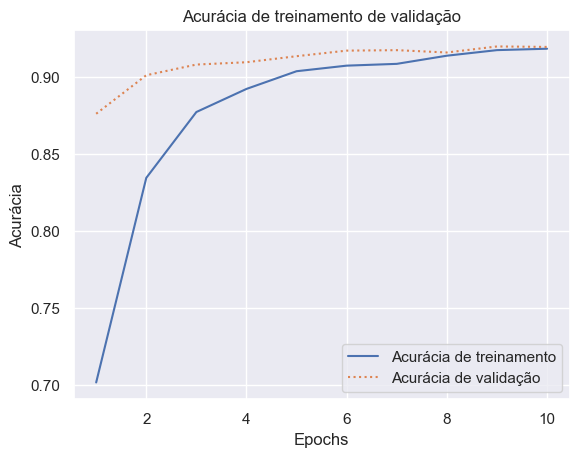

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Acurácia de treinamento')
plt.plot(epochs, val, ':', label='Acurácia de validação')
plt.title('Acurácia de treinamento de validação')
plt.xlabel('Epochs')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')
plt.plot()